<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты,-настройки-и-доп.-функции" data-toc-modified-id="Импорты,-настройки-и-доп.-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты, настройки и доп. функции</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#KNeighborsRegressor-&amp;-LinearRegression" data-toc-modified-id="KNeighborsRegressor-&amp;-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>KNeighborsRegressor &amp; LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor-&amp;-CatBoostRegressor" data-toc-modified-id="RandomForestRegressor-&amp;-CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor &amp; CatBoostRegressor</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Prophet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорты, настройки и доп. функции

In [1]:
!pip install -U scikit-learn -q
!pip install matplotlib==3.4 -q # немношк обновим, что б графики сделать покрасивее(было 3.3.4)
!pip install prophet -q
!pip install shap -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import pandas as pd
import time

from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [3]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [4]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
def cross_params(cross_seach):
    """Визуализация параметров кросс-валидации"""
    df_cg=pd.DataFrame(cross_seach.cv_results_)[
    ['rank_test_score', 'mean_test_score','params', 'mean_fit_time']
    ].sort_values('rank_test_score')[:5].reset_index(drop=True)
    print("Парамерты лучшей модели",cross_seach.best_params_)
    print("RMSE с лучшими гиперпараметрами на кросс-валидации :", cross_seach.best_score_)
    display(df_cg)

### Загрузка данных

In [6]:
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    df_taxi.name = 'df_taxi'
    df_taxi.index.name=None
except:
    df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    df_taxi.name = 'df_taxi'
    df_taxi.index.name=None

In [7]:
df_taxi.sort_index(inplace=True)
df_taxi.head(5)

,num_orders
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
display(df_taxi.info())
df_taxi.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Промежуточные выводы:**
- данные успешно загружены;
- имеем датасет из 26496, пропусков нет, типизация данных корректна;
- промежуток между наблюдениями 10 минут, цевая переменная колеблется от 0 до 119, среднее значение 14, стандартное отклонение 9, 75% наблюдений меньше 19.

## Анализ

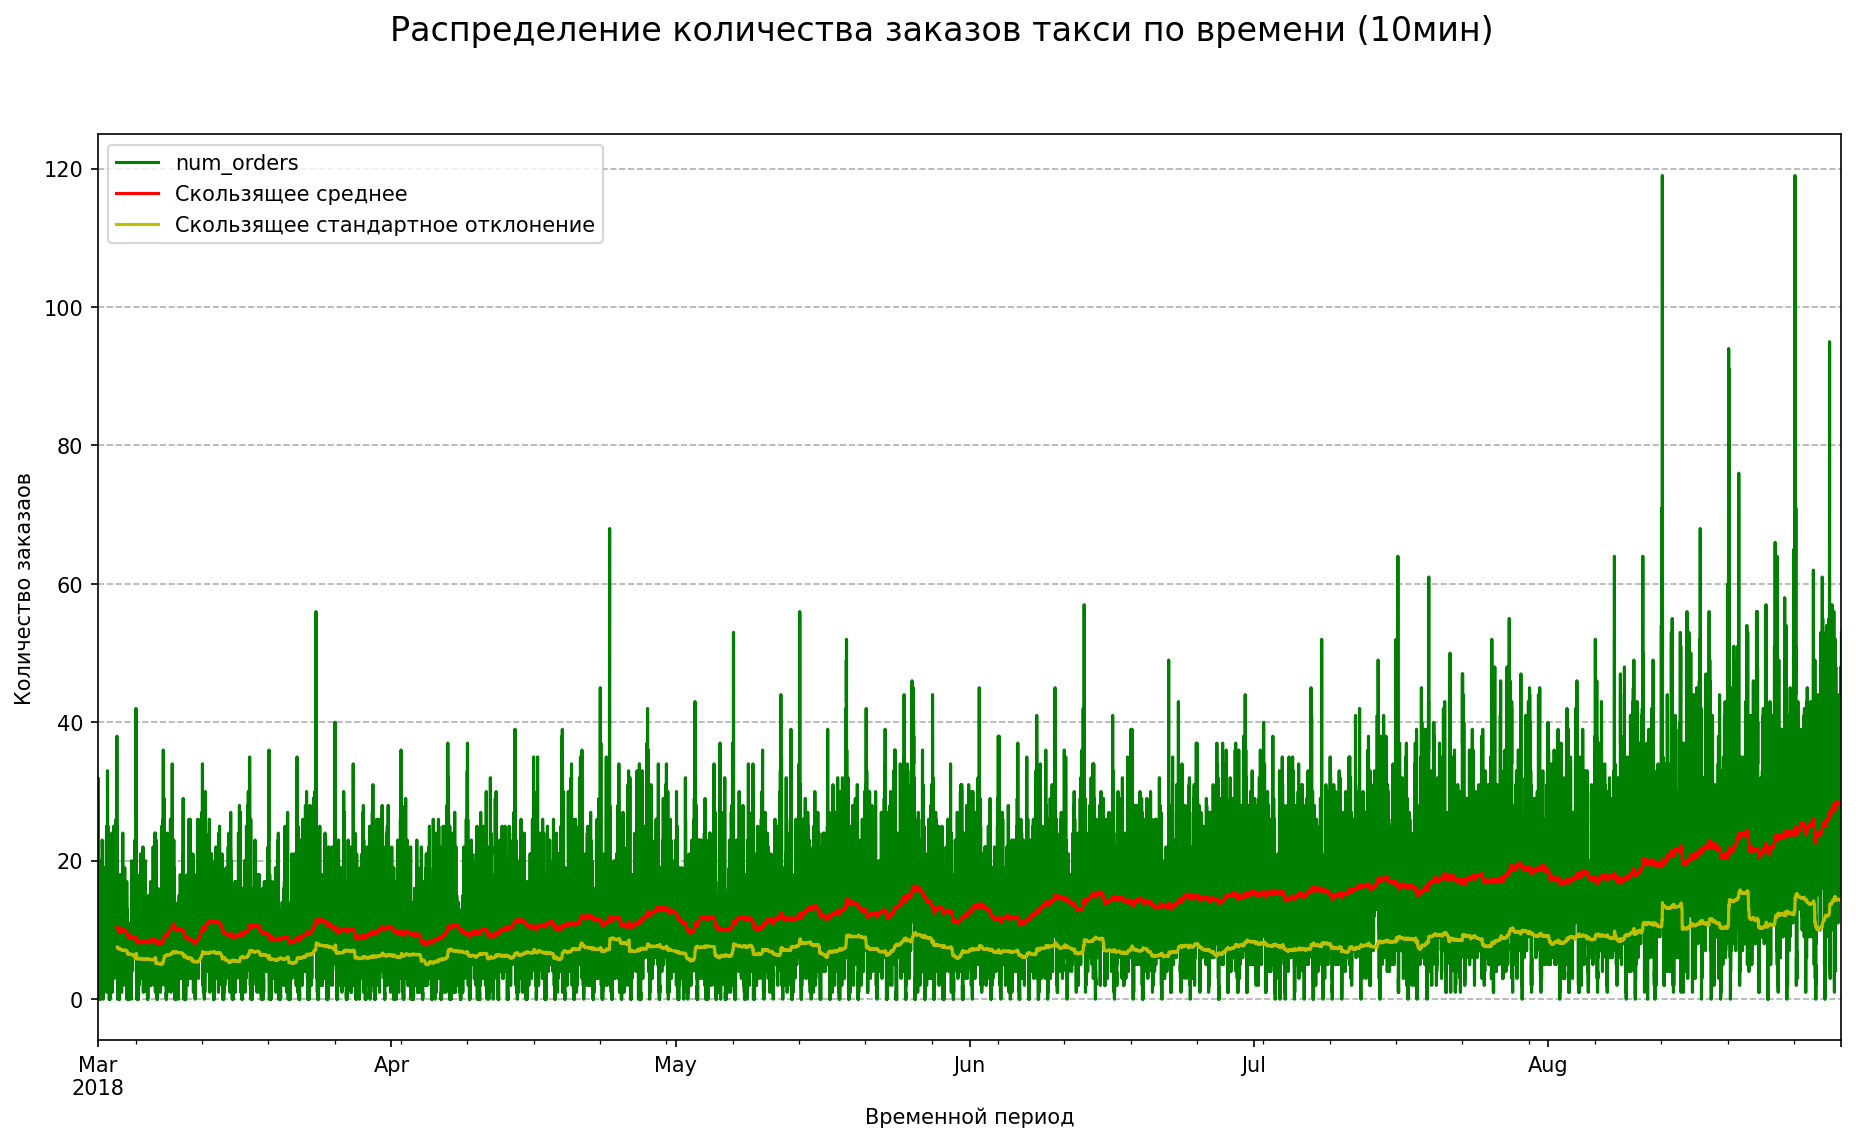

In [9]:
fig, ax = plt.subplots(dpi=150, figsize=(15,8))
df_taxi.plot(ax=ax, color='g')
df_taxi['num_orders'].rolling(300).mean().plot(ax=ax, color='r', label='Скользящее среднее')
df_taxi['num_orders'].rolling(300).std().plot(ax=ax, color='y', label='Скользящее стандартное отклонение')
fig.suptitle("Распределение количества заказов такси по времени (10мин)", fontsize=16)
plt.grid(True, axis='y', linestyle='--')
plt.legend()
plt.xlabel("Временной период")
plt.ylabel("Количество заказаов");

In [10]:
# проведем расширенный тест Дики-Фуллера для проверки стационарности временного ряда
# Ho (нулевая гипотеза): данные временного ряда нестационарны.
# H1 (альтернативная гипотеза): данные временного ряда являются стационарными.

values = df_taxi['num_orders']
# применяем тест к значениям количества заказов
res = adfuller(values)
 
# Выводим статистики
# Чем меньше значение статистики, тем больше вероятность отвергнуть гипотезу Ho
print('Cтатистика расширенного теста Дики-Фуллера: %f' % res[0])
#если p > 0,05, нулевая гипотеза не отвергается, в противном случае, если p <= 0,05, нулевая гипотеза отвергается
# т.е. при очень малом p вероятность получить такие значения при нестационарном временном ряде крайне малы
print('p-value: %f' % res[1])
 
# значения используются для сравнения с рассчитанной статистикой.
print('Критические значения теста на разных уровнях значимости:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Cтатистика расширенного теста Дики-Фуллера: -12.548885
p-value: 0.000000
Критические значения теста на разных уровнях значимости:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Исходя из графиков скользящего среднего и скользящего среднего отклонения можно предположить стационарность данного временного ряда.
Кроме того при проведении теста Дики-Фуллера мы получили практически нулевое p-значение указывает на крайне малую вероятность нулевой гипотезы и позволяет с большой вероятностью ее отвергнуть в пользу альтернативной, статистика также намного меньше всех критических значений, что указывает на сильную статистическую значимость и стационарность временного ряда.

На графике видно, что тренд восходящий, причем с увеличением времени максимальные значения увеличиваются. Но пока данные слишком шумные. Ресемплируем датасет по 1 часу, как указано в задании. 

In [11]:
df_taxi = df_taxi.resample('1H').sum()
df_taxi.head()

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


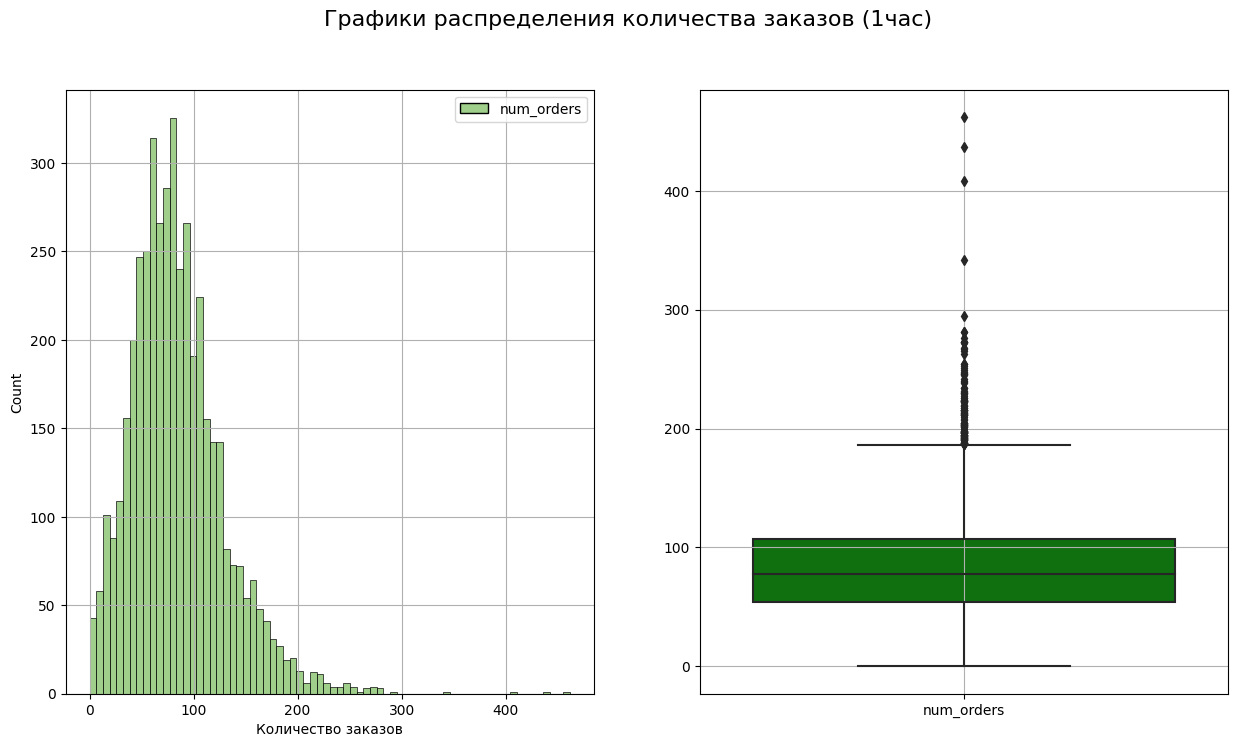

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000



In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8), dpi=100)
sns.histplot(data=df_taxi, palette='summer',ax=axes[0])
sns.boxplot(data=df_taxi, color='g',ax=axes[1])
axes[0].grid(True)
axes[0].set_xlabel('Количество заказов')
axes[1].grid(True)
fig.suptitle('Графики распределения количества заказов (1час)', fontsize=16)
plt.show()
print(df_taxi.describe())
print()

Распределение похоже на нормальное, присутсттвует значительное количество выбросов,  но как мы видели на временном графике, это скорее связано с развитием сервиса и ростом заказов.

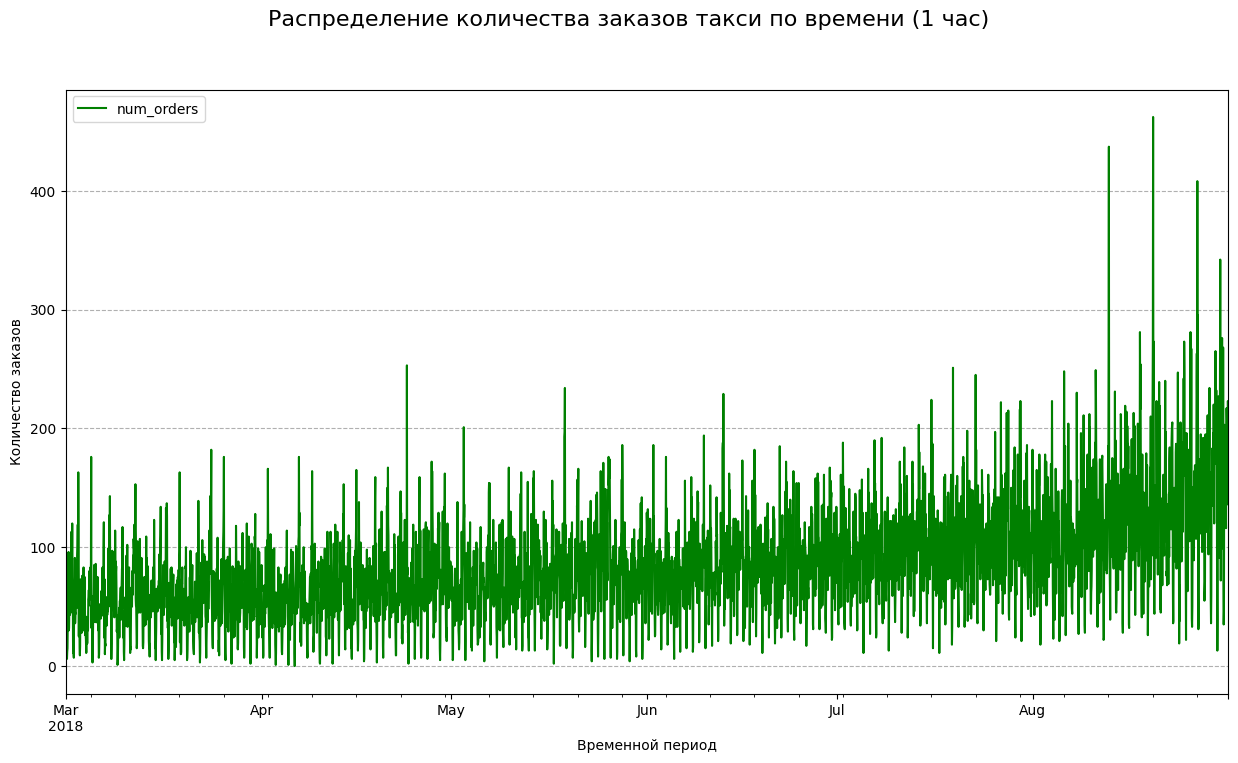

In [13]:
fig, ax = plt.subplots(dpi=100, figsize=(15,8))
df_taxi.plot(ax=ax, color='g')
fig.suptitle("Распределение количества заказов такси по времени (1 час)", fontsize=16)
plt.grid(True, axis='y', linestyle='--')
plt.xlabel("Временной период")
plt.ylabel("Количество заказов");

Разложим данные на тренд и сезонные компоненты, что бы посмотреть подробнее.

In [14]:
decomposed = seasonal_decompose(df_taxi)

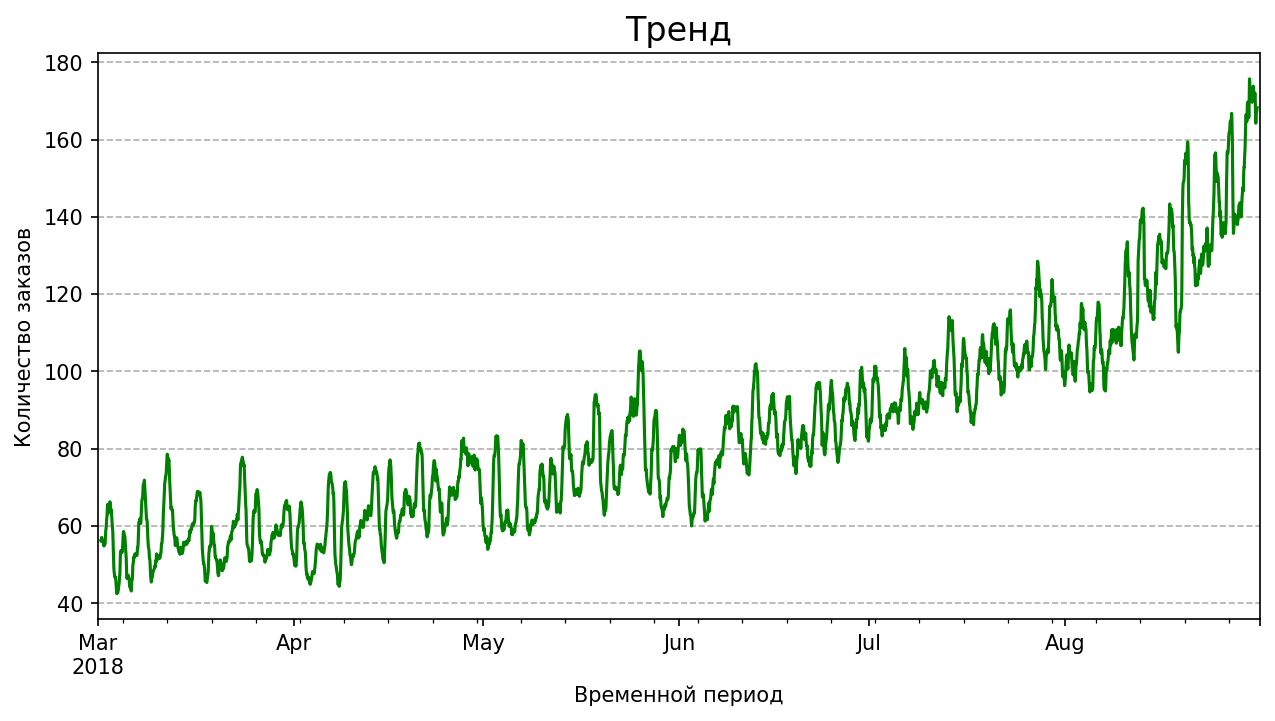

In [15]:
plt.figure(figsize=(10, 5), dpi=150)
decomposed.trend.plot(ax=plt.gca(), color='g')
plt.title('Тренд', fontsize=16)
plt.grid(True, axis='y', linestyle='--')
plt.xlabel("Временной период")
plt.ylabel("Количество заказов");

Убеждаемся, что тренд восходящий, сервис развивается - это хорошо.

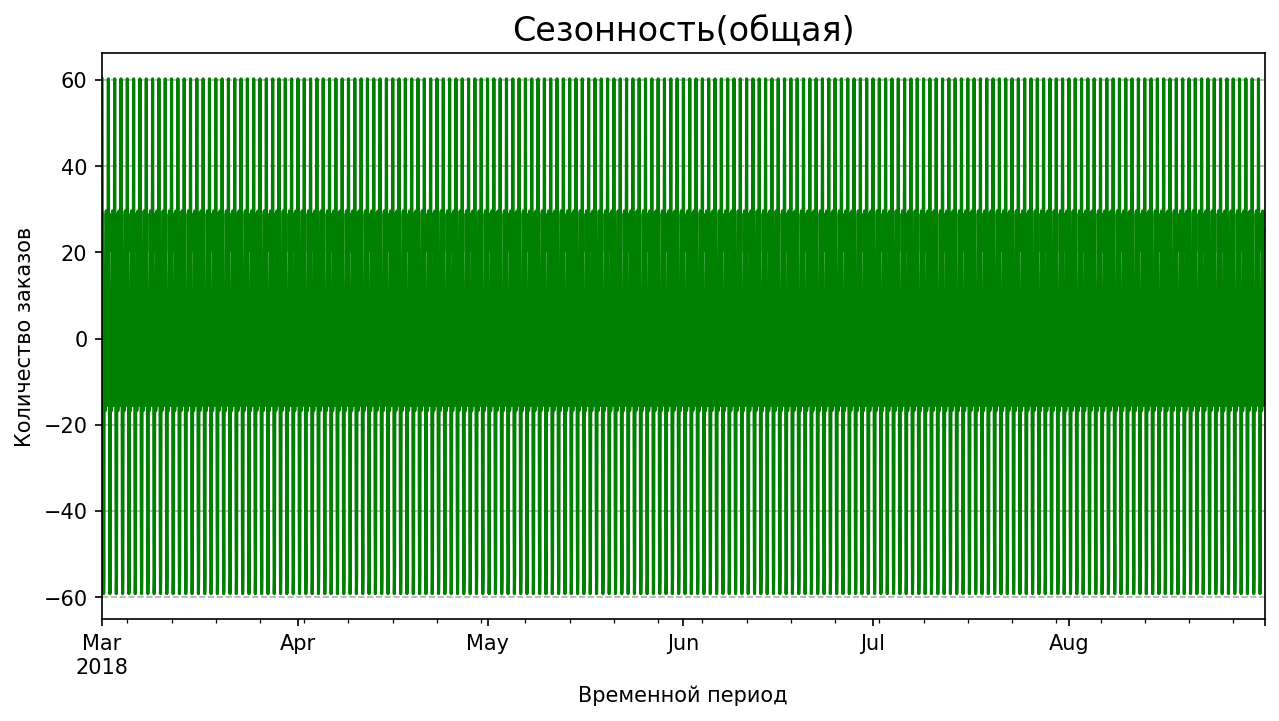

In [16]:
plt.figure(figsize=(10, 5), dpi=150)
decomposed.seasonal.plot(ax=plt.gca(), color='g')
plt.title('Сезонность(общая)', fontsize=16)
plt.grid(True, axis='y', linestyle='--')
plt.xlabel("Временной период")
plt.ylabel("Количество заказов");

Сезонность стоит посмотреть на меньшем временном отрезке.

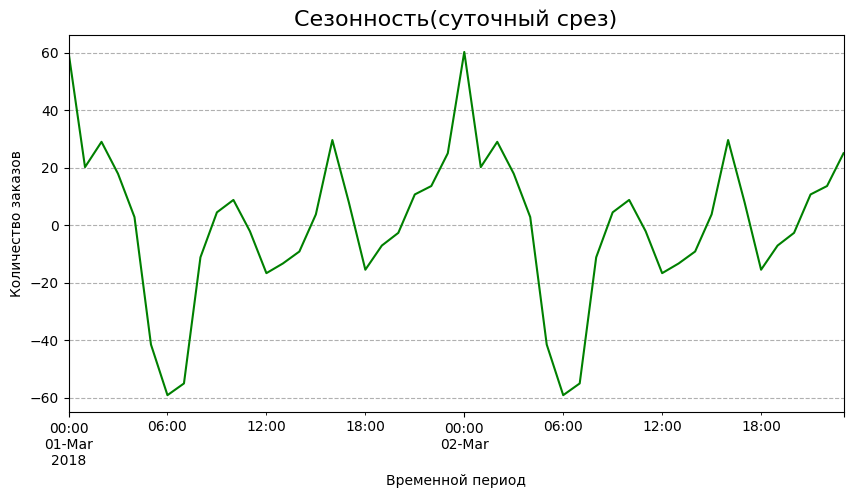

In [17]:
plt.figure(figsize=(10, 5), dpi=100)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), color='g')
plt.title('Сезонность(суточный срез)', fontsize=16)
plt.grid(True, axis='y', linestyle='--')
plt.xlabel("Временной период")
plt.ylabel("Количество заказов");

Видим что у нас есть несколько пиков активности, когда в течении дня бум заказов приходится на 00-01 ночи, а резкое снижение происходит ококло 06 утра.

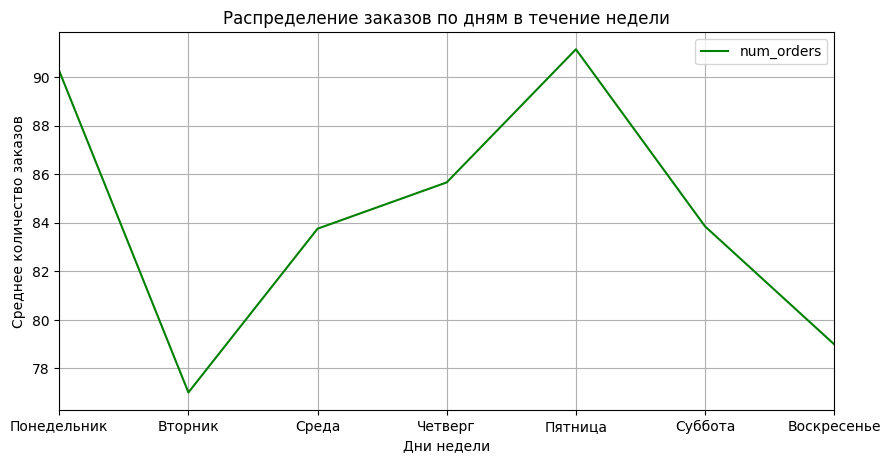

In [18]:
# Распределение заказов по дням в течение недели
fig, ax = plt.subplots(dpi=100, figsize=(10,5))
df_taxi.groupby(df_taxi.index.weekday).mean().rename( 
    index={0:'Понедельник', 1:'Вторник', 2:'Среда', 3:'Четверг', 4:'Пятница', 5:'Суббота', 6:'Воскресенье'}
).plot(
    title='Распределение заказов по дням в течение недели', 
    xlabel='Дни недели', 
    ylabel='Среднее количество заказов',
    xlim=(0, 6), 
    grid=True, 
    ax=ax, 
    color='g'
);

Если посмотреть средние значения в группировке по дням недели, то можно увидеть закономерность роста заказов в пт и спад во вторник.

На основе выше построенных графиков делаем вывод, что в данные стоит добавить временную разбивку по дням недели, часу заказа, так же добавим значения дня месяца.

In [19]:
df_taxi['day'] = df_taxi.index.day
df_taxi['dayofweek'] = df_taxi.index.dayofweek
df_taxi['hour'] = df_taxi.index.hour
df_taxi.head()

,num_orders,day,dayofweek,hour
2018-03-01 00:00:00,124,1,3,0
2018-03-01 01:00:00,85,1,3,1
2018-03-01 02:00:00,71,1,3,2
2018-03-01 03:00:00,66,1,3,3
2018-03-01 04:00:00,43,1,3,4


In [20]:
def make_features(data, max_lag, roll_list):
    """Функция для добавления сдвигов и скользящих средних."""
    for x in range(1, max_lag+1):
        data[f'lag_{x}'] = data['num_orders'].shift(x)
    for x in roll_list:
        data[f'roll_mean_{x}'] = data['num_orders'].shift().rolling(x).mean()

Учитывая суточную и недельную сезонность добавим скользящие окна с размером сутки, двое суток и неделя, так же попробуем добавить сдвиги до двух суток (48 часов).

In [21]:
roll_list_2=[24, 48, 168]
df_taxi_f = df_taxi.copy()
make_features(df_taxi_f, 48, roll_list_2)
df_taxi_f.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,roll_mean_24,roll_mean_48,roll_mean_168
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Промежуточные выводы**:
 - просемплировали данные на 1ч в соответсвии с заданием,
 - оценили стационарность ряда, графики и  тест Дики-Фуллера указывают на стационарность временнного ряда,
 - выявили возрастающий тренд, количество заказов с кадым месяцем растет,
 - выявили суточные и недельные закономерности - пик заказов приходится на 12 ночи, минимум на 6 часов утра, так же больше всего закзов поступает в пятницу, недельные минимумы - воскресенье и вторник,
 - для неспециализированных моделей создали дополнительные признаки - скользящее среднее с интервалами(24, 48, 168 часов) и сдвиги до 2 суток(48 часов).

## Обучение

Для прогнозирования построим несколько моделей: попробуем простую линейную и knn с раными скалерами, RandomForestRegressor и CatBoostRegressor на нескалированных данных, а так же Prophet из дополнительно установленной библиотеки, она спецтализируется именно на временных рядах.

Поиск будем осуществлять при помощи GridSearch и записывать лучшие варианты в отдельный датафрейм для дальнейшего выбора и сравнения.

In [22]:
train_f, test_f = train_test_split(df_taxi_f, shuffle=False, test_size=TEST_SIZE)
train_f = train_f.dropna()


X_train = train_f.drop(columns=['num_orders'])
y_train = train_f['num_orders']

### KNeighborsRegressor & LinearRegression

In [23]:
#DF для сравнений
df_scoring=pd.DataFrame(columns=['model', 'RMSE_train'])

In [24]:
rmse_score = make_scorer(root_mean_squared_error, greater_is_better = False)

In [25]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), X_train.columns)
    ], 
    remainder='passthrough'
)
pipe_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_1 = [
    # словарь для модели KNeighborsRegressor()
        {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': [2, 5, 10, 15],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
]

search_1 = GridSearchCV(pipe_1, param_1, cv=TimeSeriesSplit(), scoring=rmse_score, verbose=1)

In [26]:
search_1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_...
             param_grid=[{'models': [KNeighborsRegressor()],
                          'models__n_neighbors': [2, 5, 10, 15],
                          'preprocessor__num': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [27]:
best_m_1=search_1.best_estimator_
cross_params(search_1)

Парамерты лучшей модели {'models': LinearRegression(), 'preprocessor__num': StandardScaler()}
RMSE с лучшими гиперпараметрами на кросс-валидации : -24.789429742172356


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,-24.789430,"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}",0.139847
1,1,-24.789430,"{'models': LinearRegression(), 'preprocessor__num': 'passthrough'}",0.136750
2,3,-24.789430,"{'models': LinearRegression(), 'preprocessor__num': MinMaxScaler()}",0.155726
3,4,-24.789430,"{'models': LinearRegression(), 'preprocessor__num': RobustScaler()}",0.128355
4,5,-25.069529,"{'models': KNeighborsRegressor(), 'models__n_neighbors': 10, 'preprocessor__num': StandardScaler()}",0.008192


In [28]:
df_scoring.loc[len(df_scoring.index)]=(search_1.best_params_['models'], -search_1.best_score_)
df_scoring

,model,RMSE_train
0,LinearRegression(),24.78943


### RandomForestRegressor & CatBoostRegressor

In [29]:
pipe_2 = Pipeline([
    ('models', LinearRegression())
])

param_2 = [  
    {
      'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
      'models__n_estimators' : [64, 128],
      'models__max_depth': [4, 6], 

    },
    
    {
       'models': [CatBoostRegressor(random_state=RANDOM_STATE, logging_level='Silent')],
       'models__iterations': [150, 200],
       'models__learning_rate': [0.1, 0.15],
       'models__depth': [5, 7],
    }
]

search_2 = GridSearchCV(pipe_2, param_2, cv=TimeSeriesSplit(), scoring=rmse_score, verbose=1)

In [30]:
search_2.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('models', LinearRegression())]),
             param_grid=[{'models': [RandomForestRegressor(random_state=42)],
                          'models__max_depth': [4, 6],
                          'models__n_estimators': [64, 128]},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>],
                          'models__depth': [5, 7],
                          'models__iterations': [150, 200],
                          'models__learning_rate': [0.1, 0.15]}],
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [31]:
best_m_2=search_2.best_estimator_
cross_params(search_2)

Парамерты лучшей модели {'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 7, 'models__iterations': 200, 'models__learning_rate': 0.1}
RMSE с лучшими гиперпараметрами на кросс-валидации : -24.104289342130354


,rank_test_score,mean_test_score,params,mean_fit_time
0,1,-24.104289,"{'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 7, 'models__iterations': 200, 'models__learning_rate': 0.1}",3.541580
1,2,-24.154080,"{'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 7, 'models__iterations': 150, 'models__learning_rate': 0.1}",2.803543
2,3,-24.191002,"{'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 5, 'models__iterations': 200, 'models__learning_rate': 0.1}",1.655339
3,4,-24.284127,"{'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 5, 'models__iterations': 150, 'models__learning_rate': 0.1}",1.402783
4,5,-24.318162,"{'models': <catboost.core.CatBoostRegressor object at 0x7fe97e51ea60>, 'models__depth': 5, 'models__iterations': 150, 'models__learning_rate': 0.15}",1.432719


In [32]:
df_scoring.loc[len(df_scoring.index)]=('CatBoostRegressor', -search_2.best_score_)
df_scoring

,model,RMSE_train
0,LinearRegression(),24.789430
1,CatBoostRegressor,24.104289


###  Prophet

Для прогнозирования с помощью prophet вернем исходный датасет и переименуем признаки.

In [33]:
data = df_taxi.loc[:,['num_orders']]

In [34]:
data.head()

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [35]:
data.columns=['y']
data['ds'] = data.index
data.reset_index(drop=True,inplace=True)
data.head()

,y,ds
0,124,2018-03-01 00:00:00
1,85,2018-03-01 01:00:00
2,71,2018-03-01 02:00:00
3,66,2018-03-01 03:00:00
4,43,2018-03-01 04:00:00


In [36]:
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
print(train.shape, test.shape)

(3974, 2) (442, 2)


In [37]:
m = Prophet(changepoint_prior_scale=0.5,
            seasonality_mode='multiplicative',
            daily_seasonality=7,
            weekly_seasonality=6)
m.fit(train)

09:38:07 - cmdstanpy - INFO - Chain [1] start processing
09:38:08 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
manual_model_cv = cross_validation(m, horizon = '18 days', parallel="processes")
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p.head()

09:38:08 - cmdstanpy - INFO - Chain [1] start processing
09:38:09 - cmdstanpy - INFO - Chain [1] start processing
09:38:09 - cmdstanpy - INFO - Chain [1] start processing
09:38:10 - cmdstanpy - INFO - Chain [1] start processing
09:38:10 - cmdstanpy - INFO - Chain [1] start processing
09:38:11 - cmdstanpy - INFO - Chain [1] start processing
09:38:11 - cmdstanpy - INFO - Chain [1] start processing
09:38:11 - cmdstanpy - INFO - Chain [1] start processing
09:38:12 - cmdstanpy - INFO - Chain [1] done processing
09:38:12 - cmdstanpy - INFO - Chain [1] done processing
09:38:13 - cmdstanpy - INFO - Chain [1] done processing
09:38:15 - cmdstanpy - INFO - Chain [1] done processing
09:38:17 - cmdstanpy - INFO - Chain [1] done processing
09:38:17 - cmdstanpy - INFO - Chain [1] start processing
09:38:17 - cmdstanpy - INFO - Chain [1] start processing
09:38:17 - cmdstanpy - INFO - Chain [1] done processing
09:38:18 - cmdstanpy - INFO - Chain [1] done processing
09:38:18 - cmdstanpy - INFO - Chain [1

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,756.087086,27.497038,20.835845,0.277914,0.204791,0.277598,0.737584


In [39]:
df_scoring.loc[len(df_scoring.index)]=('Prophet', manual_model_p.rmse[0])

In [40]:
df_scoring

,model,RMSE_train
0,LinearRegression(),24.789430
1,CatBoostRegressor,24.104289
2,Prophet,27.497038


**Промежуточные выводы:**
 - рассмотрев 5 моделей с различными гиперпараметрами на кросс валидации можем сделать вывод, что лучше всего справилась **CatBoostRegressor ('models__depth': 5, 'models__iterations': 200, 'models__learning_rate': 0.1)** ;
 - стоит отметить что линейная модель отличается от нее незначительно, на тренировочных данных при кросс-валидации всего 0,7ед.;   - чуть хуже показала себя специализированная Prophet, но ее преимущество в том, что данные для нее готовить не было необходимости.
 Поэтому дать четкое определение тому, какая модель для прогноза лучше несколько затруднительно, здесь будет зависеть от задачи и времени на исполнение.
 
 Мы остановимся на лучшем значении **RMSE 24.1 и CatBoostRegressor**.

## Тестирование

Пробуем модель на тестовых данных.

In [41]:
pred = best_m_2.predict(test_f.drop(columns=['num_orders']))
display(best_m_2)
print("RMSE тестовой выборки лучшей модели:", root_mean_squared_error(test_f['num_orders'], pred))

Pipeline(steps=[('models',
                 <catboost.core.CatBoostRegressor object at 0x7fe9f5c3c5b0>)])

RMSE тестовой выборки лучшей модели: 42.28616364266268


Успех! Метрика **RMSE=42** соответствует требованию задания. Модель *CatBoostRegressor с гиперпараментрами ('models__depth': 5, 'models__iterations': 200, 'models__learning_rate': 0.1)* на обработанных данных с доп признаками справилась с прогнозированием.

In [42]:
# проверим модель на адекватность
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
pred_dum = dummy_regressor.predict(test_f.drop(columns=['num_orders']))
print("RMSE тестовой выборки dummy модели:", root_mean_squared_error(test_f['num_orders'], pred_dum))

RMSE тестовой выборки dummy модели: 83.97941361168559


Работа проведена не зря, наша модель работает и предсказывает вдвое лучше, чем усреднение по датасету.

Посмотрим на важность признаков:

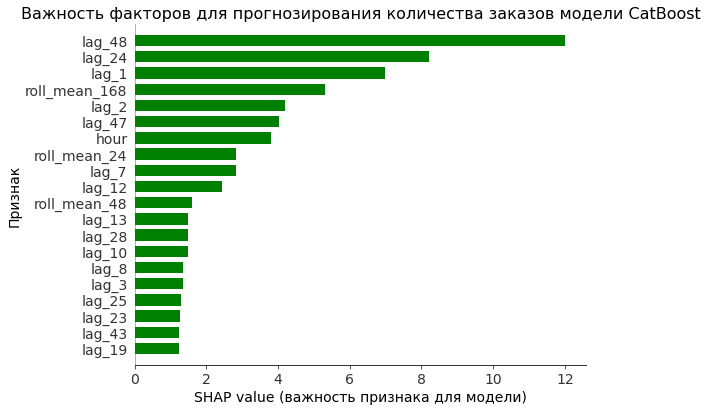

In [43]:
# Explain feature importance using SHAP
explainer = shap.Explainer(best_m_2[0])
shap_values = explainer.shap_values(test_f.drop(columns=['num_orders']))
 
# Create a summary plot
shap.summary_plot(shap_values, test_f.drop(columns=['num_orders']), plot_type="bar", plot_size= 0.2, color='g', show=False)
fig, ax = plt.gcf(), plt.gca()
# Настройка подписей
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (важность признака для модели)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность факторов для прогнозирования количества заказов модели CatBoost', fontsize=16)
plt.show()

Наиболее значимыми признаками для модели CatBoost стали lag_48 и lag_1 - т.е сдвиги на 48 часов и час соответственно.

Посмотрим как предсказания отличаются от реальных данных на графике.

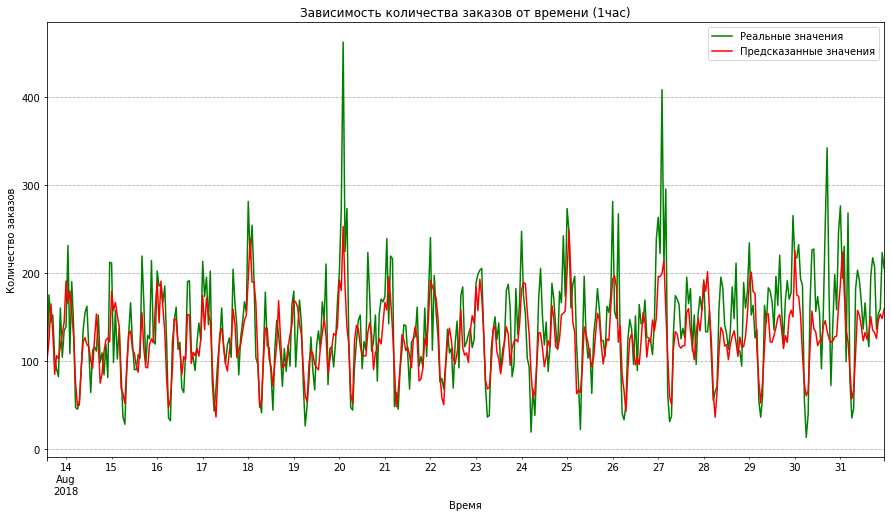

In [44]:
y_test=test_f.loc[:,['num_orders']]
y_test['preds'] = pred
y_test['num_orders'].plot(figsize=(15, 8), label='Реальные значения', color='g')
y_test['preds'].plot(label='Предсказанные значения', color='r')
plt.grid(True, axis='y', linestyle='--')
plt.legend()
plt.title('Зависимость количества заказов от времени (1час)')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

Модель неплохо предсказывает средние значения и моменты спада заказов, а вот яркие 'всплески' активности заказов по выходным (20 и 27 это воскресенья) не улавливает. Так же по графику видно, что ближе к концу месяца число реальных заказов в целом возрастает, а модель эту закономерность не уловила. Для дальнейшего развития стоит попробовать обучить ее на большем количестве данных.

**Промежуточные выводы:**
- выбранная модель справилась с предсказанием числа заказов - метрика RMSE=42 соответствует условию исследования ***(RMSE<48)***;
- модель проверили на адекватность и ее предсказания значительно лучше среднего значения предсказанного рандомной моделью ***( CatBoost RMSE 42 < Dummy RMSE 84)***,
- самыми важными признаками модель выделяет ***lag_48 и lag_1*** - т.е сдвиги на 48 часов и час соответственно,
- модель хорошо уловила общие закономерности и моменты спада активности, но плохо предсказывает моменты резкого возрастания заказов в выодные дни (воскресенье) и общее возрастание числа заков к концу месяца (последние 4 дня прогноза).

## Выводы

 - загружены имеющиеся данные из файла;
 - проведен анализ данных :
    - пропуски данных не обнаружены,
    - рассмотрели распределение количественных признаков;
    - выбросов не обнаружено;
    - проанализировали тренды и сезонность,
    - прроверили временной ряд на стационарность,
 - пропусков в данных не обнаружено, типизация данных во всех датафреймах корректна;
 
 - построили и использовали 2 пайплайна для различных моделей:
    - построили пайплайн с моделями KNeighborsRegressor и LinearRegression используя различные гиперпаметры и скалеры для каждой;
    - построили пайплайн с моделями RandomForestRegressor и CatBoostRegressor,
    - использовали дополнительную библиотеку prophet для постоения специализированной модели,
    - по итогу выделили самую успешную модель:
        - *CatBoostRegressor с гиперпараментрами ('models__depth': 5, 'models__iterations': 200, 'models__learning_rate': 0.1)*;
        - наиболее значимые признаки для модели lag_48 и lag_1 - т.е сдвиги на 48 часов и час соответственно.
        - метрика RMSE у лучшей модели на тестовых данных составляет -  42, что соответствует критерию успеха < 48.
        - проверили модель на адекватность,
        - модель хуже предсказывает резкие всплески высокого спроса в выходные дни и возросшую активность в конце тестового месяца, это возмрожно удастся в будущем обойти если расширить обучающий датасет.